## Maximal Update Parameterization

In this problem, we will examine the training of a simple MLP with hidden layers of varying widths. We will then investigate the maximal update parameterization (muP) which will allow us to use a single global learning rate to jointly train layers of any width.

Note: This homework question is new this year and it is messier than usual. We felt it was worth it to get it out so you can play with these new techniques. If you're feeling stuck, don't hesistate to ask questions on Ed.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt

%matplotlib inline

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MLP(nn.Module):
    def __init__(self, input_size=784, hidden_sizes = [8, 16, 32, 64, 128], num_classes=10):
        super(MLP, self).__init__()
        all_hidden_sizes = [input_size] + hidden_sizes + [num_classes]
        self.layers = nn.ModuleList()
        for i in range(len(all_hidden_sizes)-1):
            self.layers.append(nn.Linear(all_hidden_sizes[i], all_hidden_sizes[i+1]))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        activations = []
        x = x.view(x.size(0), -1)  # Flatten: (batch_size, 28*28)
        for layer in self.layers[:-1]:
            x = self.sigmoid(layer(x))
            activations.append(x)
        x = self.layers[-1](x)
        activations = activations[1:]
        return x, [a.detach() for a in activations]

# Load MNIST data
(train_images, train_labels), (valid_images, valid_labels) = mnist.load_data()

# Normalize pixel values to [0, 1]
train_images = train_images.astype(np.float32) / 255.0
valid_images = valid_images.astype(np.float32) / 255.0

# Convert to PyTorch tensors
train_images = torch.from_numpy(train_images)
train_labels = torch.from_numpy(train_labels).long()
valid_images = torch.from_numpy(valid_images)
valid_labels = torch.from_numpy(valid_labels).long()

def rms(x, dim):
    return torch.sqrt(torch.mean(x**2, dim=dim))


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
from torch.optim.optimizer import Optimizer
from typing import Any
class SimpleAdam(Optimizer):
    def __init__(
        self,
        params: Any,
        lr: float = 1e-1,
        b1: float = 0.9,
        b2: float = 0.999,
    ):
        defaults = dict(lr=lr, b1=b1, b2=b2,)
        super(SimpleAdam, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data

                state = self.state[p]
                if len(state) == 0: # Initialization
                    state["step"] = torch.tensor(0.0)
                    state['momentum'] = torch.zeros_like(p)
                    state['variance'] = torch.zeros_like(p)

                state['step'] += 1
                m = state['momentum']
                m.lerp_(grad, 1-group["b1"])
                v = state['variance']
                v.lerp_(grad**2, 1-group["b2"])

                m_hat = m / (1 - group["b1"]**state['step'])
                v_hat = v / (1 - group["b2"]**state['step'])
                u = m_hat / (torch.sqrt(v_hat) + 1e-16)

                p.add_(u, alpha=-group['lr'])
        return None

[torch.Size([64, 16]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([64, 256]), torch.Size([64, 256]), torch.Size([64, 1024])]


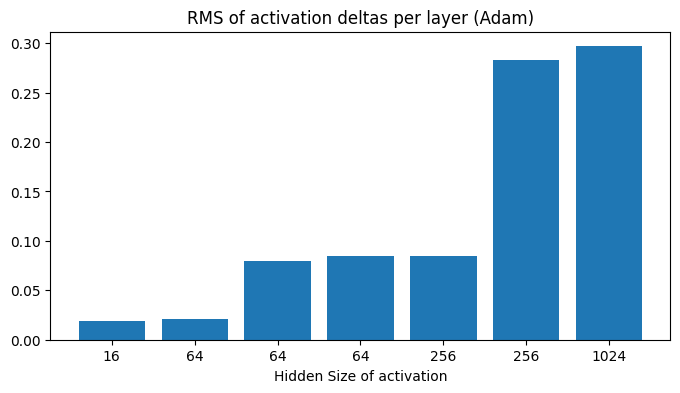

In [3]:
batch_idx = np.random.randint(0, len(train_images), size=64)
def train_one_step(mlp=MLP, hiddens=[8, 16, 64, 64, 64, 256, 256, 1024], optimizer=SimpleAdam, label="Adam", lr=0.01):
    model = mlp(hidden_sizes=hiddens).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer(model.parameters(), lr=lr)

    prev_activations = None
    for i in range(2):
        images_batch = train_images[batch_idx]
        labels_batch = train_labels[batch_idx]
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

        optimizer.zero_grad()
        outputs, activations = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        if i > 0:
            print([a.shape for a in activations])
            activation_deltas = [a - pa for a, pa in zip(activations, prev_activations)]
            activation_deltas_rms = [torch.mean(rms(a, dim=-1)) for a in activation_deltas]
        prev_activations = activations

    # plot deltas
    deltas = np.array(activation_deltas_rms)
    fig, axs = plt.subplots(1, figsize=(8, 4))
    axs.set_title(f'RMS of activation deltas per layer ({label})')
    axs.set_xlabel('Hidden Size of activation')
    axs.bar(np.arange(deltas.shape[0]), deltas)
    axs.set_xticks(np.arange(deltas.shape[0]))
    axs.set_xticklabels(hiddens[1:])
    plt.show()
train_one_step(optimizer=SimpleAdam)

## a. Examining the norms of a heterogenous MLP.

Run the above cell, which trains a neural network for a single gradient step, then examines the effect of that step on the resulting activations. What are the dimensions of each layer in the neural network?

*Answer:* By default, there are 9 layers with the following layer dimensions:
$$
(784 \times 8), \quad
(8 \times 16), \quad
(16 \times 64), \quad
(64 \times 64), \quad
(64 \times 64), \quad
(64 \times 256), \quad
(256 \times 256), \quad
(256 \times 1024), \quad
(1024 \times 10)
$$
Note that the above chart only plots activation deltas for the hidden layers, not the input or output layers.

How does the dimensionality of the layer affect the RMS norm of the activation deltas?

*Answer:* The RMS norm approximately scales with the input dimension of the layer.

Change the widths of some of your neural network layers, and recreate the plot -- did the RMS values change as expected?

*Answer:* Yes, again we should see that the RMS values scale roughly with the input dimension of the layer.


[torch.Size([64, 16]), torch.Size([64, 128]), torch.Size([64, 64]), torch.Size([64, 128]), torch.Size([64, 256]), torch.Size([64, 512]), torch.Size([64, 1024])]


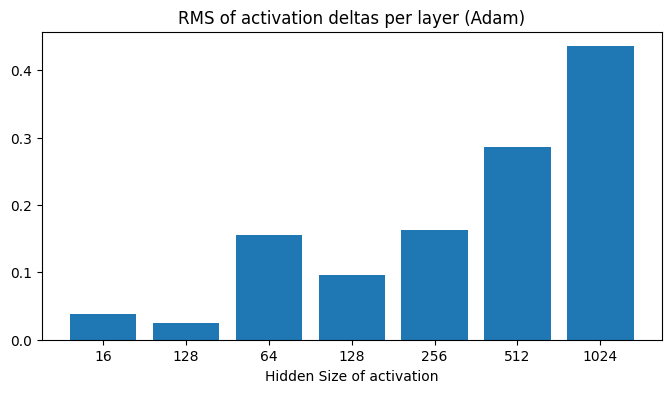

In [4]:
### Solution
train_one_step(optimizer=SimpleAdam, hiddens=[8, 16, 128, 64, 128, 256, 512, 1024])
# Changing the width of a layer will increase the update to the *following* activation vector.
###

## b. Examining the norms of the updates to the weights.

In the provided code above, we plotted the change in norms of the *activation vectors*. Now, you will examine the change in the weights themselves. Create a version of the above function that runs a single gradient step, then for each dense layer plot:
- The *Frobenius* norm of the update.
- The *spectral* norm of the update.
- The *RMS-RMS induced norm* of the update.

Which one of these norms correlates the most with the RMS norms of the activations?

*Answer:* The induced RMS norm correlates the most with the RMS norms of the activations, as it scales with the input dimension of each layer.

You should calculate your updates as `new_dense_parameter - old_dense_parameter`.

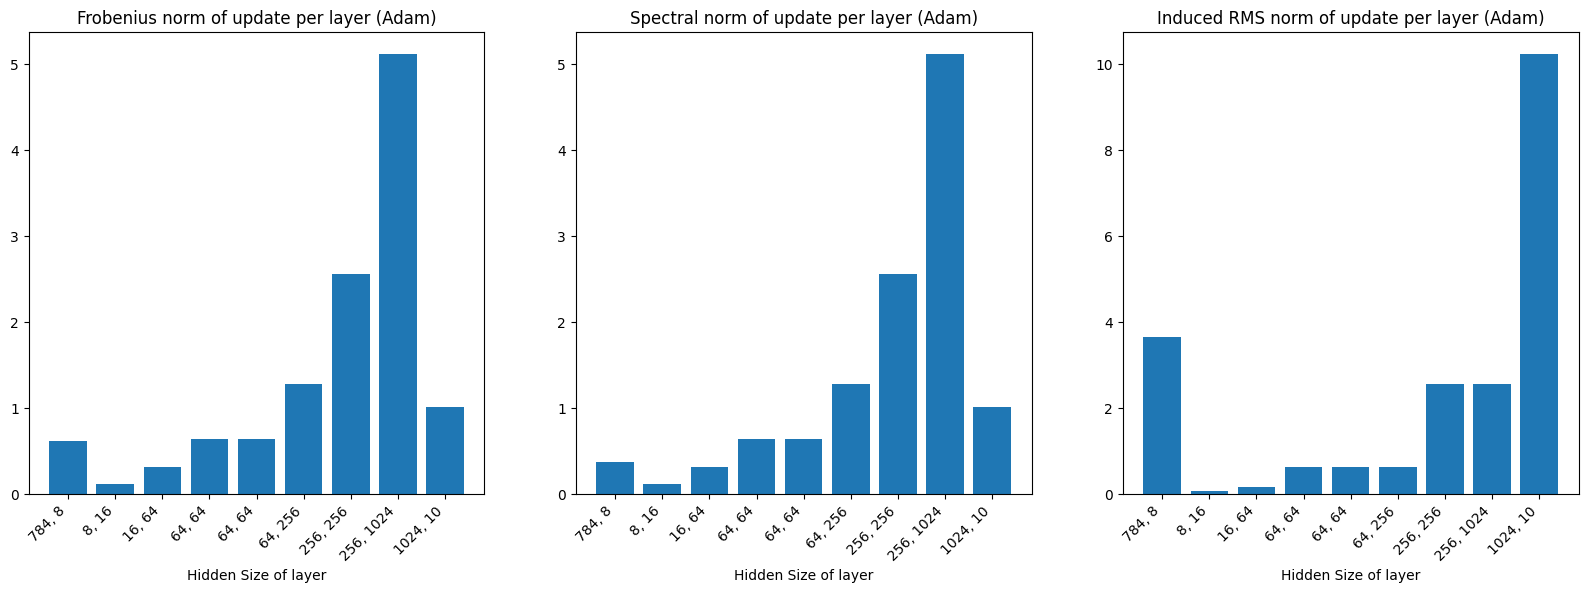

In [5]:
### Solution
batch_idx = np.random.randint(0, len(train_images), size=64)
def train_one_step_matrices(mlp=MLP, hiddens=[8, 16, 64, 64, 64, 256, 256, 1024], optimizer=SimpleAdam, label="Adam", lr=0.01):
    model = mlp(hidden_sizes=hiddens).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer(model.parameters(), lr=lr)

    old_params = [p.detach().clone() for p in model.parameters()]

    prev_activations = None
    for i in range(1):
        images_batch = train_images[batch_idx]
        labels_batch = train_labels[batch_idx]
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

        optimizer.zero_grad()
        outputs, activations = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

    new_params = [p.detach().clone() for p in model.parameters()]
    delta_params = [new_p - old_p for new_p, old_p in zip(new_params, old_params)]

    frob_norms = []
    spectral_norms = []
    induced_norms = []
    p_shapes = []

    for p in delta_params:
        if len(p.shape) == 2:
            p_shapes.append(f"{p.shape[1]}, {p.shape[0]}")
            frob_norm = torch.sqrt(torch.sum(torch.square(p))).item()
            frob_norms.append(frob_norm)
            u, s, v = torch.linalg.svd(p)
            spectral_norm = torch.max(s).item()
            spectral_norms.append(spectral_norm)
            induced_norms.append(spectral_norm * np.sqrt(p.shape[1] / p.shape[0]))


    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    axs[0].set_title(f'Frobenius norm of update per layer ({label})')
    axs[0].set_xlabel('Hidden Size of layer')
    axs[0].bar(np.arange(len(frob_norms)), frob_norms)
    axs[0].set_xticks(np.arange(len(frob_norms)), p_shapes, rotation=45, ha='right')

    axs[1].set_title(f'Spectral norm of update per layer ({label})')
    axs[1].set_xlabel('Hidden Size of layer')
    axs[1].bar(np.arange(len(spectral_norms)), spectral_norms)
    axs[1].set_xticks(np.arange(len(spectral_norms)), p_shapes, rotation=45, ha='right')

    axs[2].set_title(f'Induced RMS norm of update per layer ({label})')
    axs[2].set_xlabel('Hidden Size of layer')
    axs[2].bar(np.arange(len(induced_norms)), induced_norms)
    axs[2].set_xticks(np.arange(len(induced_norms)), p_shapes, rotation=45, ha='right')
    plt.show()
train_one_step_matrices(optimizer=SimpleAdam)

## c. Implementing muP

We will now implement muP scaling. Modify the starter code below to set a per-layer learning rate such that the resulting RMS activation-deltas are uniform scale, regardless of the layer widths. Plot the resulting activation-deltas on at least two sets of widths.

Note: Even with the correct scaling, the first 2-3 activation-deltas may have a lower norm than the rest. Can you think of a reason why this might be the case?

[torch.Size([64, 16]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([64, 256]), torch.Size([64, 256]), torch.Size([64, 1024])]


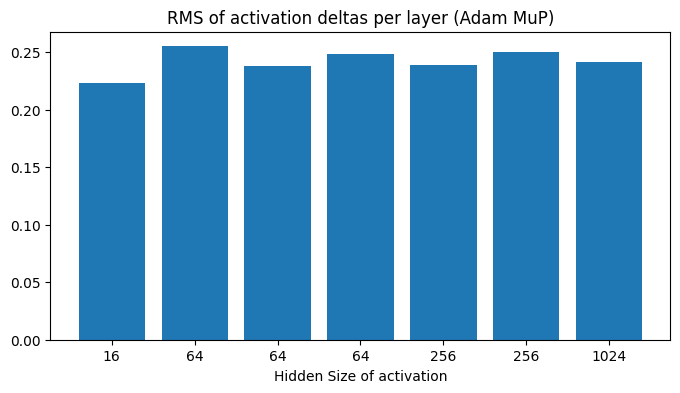

[torch.Size([64, 16]), torch.Size([64, 32]), torch.Size([64, 64]), torch.Size([64, 128]), torch.Size([64, 256]), torch.Size([64, 512]), torch.Size([64, 1024])]


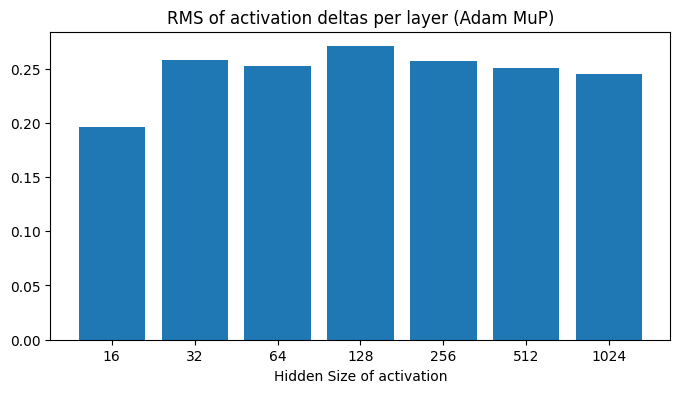

In [6]:
from torch.optim.optimizer import Optimizer
from typing import Any
class SimpleAdamMuP(Optimizer):
    def __init__(
        self,
        params: Any,
        lr: float = 1e-1,
        b1: float = 0.9,
        b2: float = 0.999,
    ):
        defaults = dict(lr=lr, b1=b1, b2=b2,)
        super(SimpleAdamMuP, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data

                state = self.state[p]
                if len(state) == 0: # Initialization
                    state["step"] = torch.tensor(0.0)
                    state['momentum'] = torch.zeros_like(p)
                    state['variance'] = torch.zeros_like(p)

                state['step'] += 1
                m = state['momentum']
                m.lerp_(grad, 1-group["b1"])
                v = state['variance']
                v.lerp_(grad**2, 1-group["b2"])

                m_hat = m / (1 - group["b1"]**state['step'])
                v_hat = v / (1 - group["b2"]**state['step'])
                u = m_hat / (torch.sqrt(v_hat) + 1e-16)

                ############################
                ### Todo: Adjust the per-layer learning rate scaling factor so per-layer RMS activation deltas are constant.
                ### Hint: The following tricks will help you retain performance when using muP scaling.
                ###  - Treat biases as a hidden layer with size (d_out, 1). You will need to use a fudge-factor of around 0.01 -- we want to keep the change in bias terms low.
                ###  - For the input layer, a fudge factor of 10 appears to help.
                ###  - For the output layer, we find it is best to ignore the muP scaling, and instead use a fixed learning rate (e.g. 0.003).
                ############################
                lr = group['lr']
                if len(u.shape) == 2:
                    if u.shape[1] == 784:
                        lr = lr * (1/u.shape[1]) * 10
                    elif u.shape[0] == 10:
                        lr = 0.003
                    else:
                        lr = lr * (1 / u.shape[1])
                else:
                    lr = (lr / 1) * 0.01

                ############################
                ############################

                p.add_(u, alpha=-lr)
        return None
train_one_step(optimizer=SimpleAdamMuP, lr=2, label="Adam MuP", hiddens=[8, 16, 64, 64, 64, 256, 256, 1024])
train_one_step(optimizer=SimpleAdamMuP, lr=2, label="Adam MuP", hiddens=[8, 16, 32, 64, 128, 256, 512, 1024])

## d. Per-Weight Multipliers

An alternative way to implement muP is to adjust the *network graph* itself, rather than the optimizer. Implement this below, and recreate the above uniformly-scaled graph when using the *Adam* (not muP) optimizer. We have disabled biases to simplify the problem.

Why is multiplying the output of a layer by a constant the same as adjusting the learning-rate of that layer (when using Adam or SignGD)?

*Answer:* Adam is invariant to scalings of the gradients, so the update itself does not change when we scale the output of our layer. Therefore, dividing the activation by $d_{in}$ does not change the weight update itself, but scales down the update's effect on the activation (i.e. the activation delta) by a factor $d_{in}$.

Note that scaling down the activation in this manner effectively scales down our weight initializations by a factor of $d_{in}$, so we must scale up our weight initializations to compensate and recover the correct muP initialization.

[torch.Size([64, 16]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([64, 256]), torch.Size([64, 256]), torch.Size([64, 1024])]


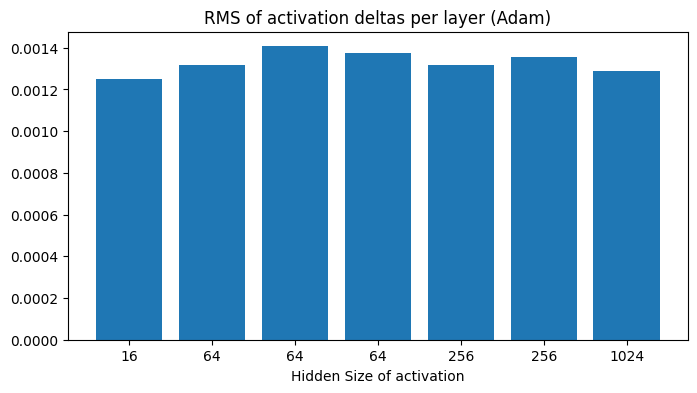

In [7]:
class ScaledMLP(nn.Module):
    def __init__(self, input_size=784, hidden_sizes = [8, 16, 32, 64, 128], num_classes=10):
        super(ScaledMLP, self).__init__()
        all_hidden_sizes = [input_size] + hidden_sizes + [num_classes]
        self.layers = nn.ModuleList()
        for i in range(len(all_hidden_sizes)-1):
            self.layers.append(nn.Linear(all_hidden_sizes[i], all_hidden_sizes[i+1], bias=False))
        self.sigmoid = nn.Sigmoid()

        ## Rescale weight initializations to account for pre-activation scaling
        with torch.no_grad():
            for layer in self.layers:
                layer.weight.mul_(layer.weight.shape[1])
        ##

    def forward(self, x):
        activations = []
        x = x.view(x.size(0), -1)  # Flatten: (batch_size, 28*28)
        for layer in self.layers[:-1]:
            x = layer(x)
            ## TODO
            p_shape = layer.weight.shape
            x = x / p_shape[1]
            ##
            x = self.sigmoid(x)
            activations.append(x)
        x = self.layers[-1](x)
        activations = activations[1:]
        return x, [a.detach() for a in activations]

train_one_step(mlp=ScaledMLP, optimizer=SimpleAdam)

## e. Hyperparameter Transfer

Run the following code, which will perform a sweep over learning rates for 3-layer MLPs of increasing width using Adam. How does the optimal learning rate change as the network increases in size?

*Answer:* The optimal learning rate tends to decrease as the network width increases. This roughly matches our intuition that gradient norms increase with layer width, so we might need to decrease the learning rate to maintain stability during training.

In the second cell, we will instead use the muP optimizer you implemented. How does the optimal learning rate work now? You should aim to show that there is a single global learning rate that works on a majority of widths. The 256-width network should achieve a loss of 0.5, comparable to Adam.

*Answer:* Most networks achieve the best performance with a learning rate of 1.0. We also see that the 256-width network using the muP optimizer matches or exceeds the performance of the Adam optimizer.


In [8]:
valid_idx = np.random.randint(0, len(train_images), size=64)
valid_images = train_images[valid_idx]
valid_labels = train_labels[valid_idx]
valid_images, valid_labels = valid_images.to(device), valid_labels.to(device)


def train_with_lr(hiddens=[64, 64, 64], optimizer=SimpleAdam, lr=0.01):
    torch.manual_seed(4)
    np.random.seed(4)
    model = MLP(hidden_sizes=hiddens).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer(model.parameters(), lr=lr)
    losses = []

    for i in range(100):
        batch_idx = np.random.randint(0, len(train_images), size=64)

        images_batch = train_images[batch_idx]
        labels_batch = train_labels[batch_idx]
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

        optimizer.zero_grad()
        outputs, _ = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            outputs_valid, _ = model(valid_images)
            valid_losses = criterion(outputs_valid, valid_labels)
            losses.append(valid_losses.item())

    return np.mean(np.array(losses)[-5:])



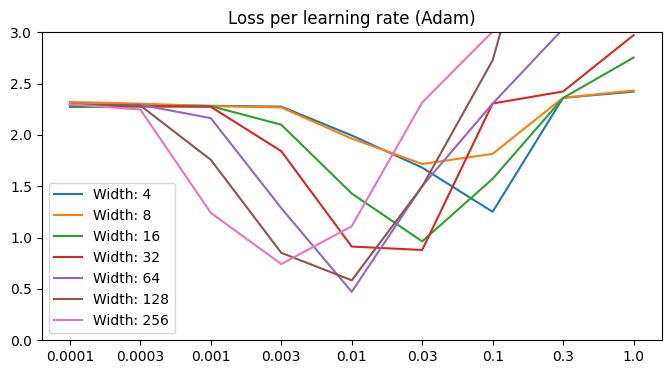

In [9]:
all_widths = [4, 8, 16, 32, 64, 128, 256]
all_lrs = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1.0]
adam_results = np.zeros((len(all_widths), len(all_lrs)))
for wi, width in enumerate(all_widths):
    for lri, lr in enumerate(all_lrs):
        loss = train_with_lr(hiddens=[width, width, width], lr=lr)
        adam_results[wi, lri] = loss

fig, axs = plt.subplots(1, figsize=(8, 4))
axs.set_title(f'Loss per learning rate (Adam)')
for wi, width in enumerate(all_widths):
    axs.plot(np.arange(len(all_lrs)), adam_results[wi], label=f'Width: {width}')
axs.set_xticks(np.arange(len(all_lrs)))
axs.set_xticklabels(all_lrs)
axs.set_ylim(bottom=0, top=3)
axs.legend()
fig.show()

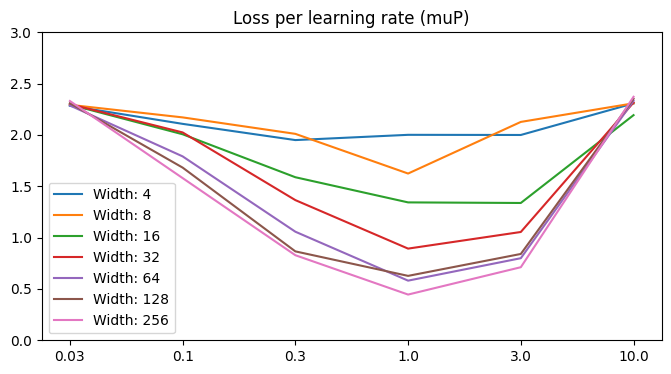

In [10]:
all_widths = [4, 8, 16, 32, 64, 128, 256]
all_lrs = [0.03, 0.1, 0.3, 1.0, 3.0, 10.0]
mup_results = np.zeros((len(all_widths), len(all_lrs)))
for wi, width in enumerate(all_widths):
    for lri, lr in enumerate(all_lrs):
        loss = train_with_lr(hiddens=[width, width, width], lr=lr, optimizer=SimpleAdamMuP)
        mup_results[wi, lri] = loss

fig, axs = plt.subplots(1, figsize=(8, 4))
axs.set_title(f'Loss per learning rate (muP)')
for wi, width in enumerate(all_widths):
    axs.plot(np.arange(len(all_lrs)), mup_results[wi], label=f'Width: {width}')
axs.set_xticks(np.arange(len(all_lrs)))
axs.set_xticklabels(all_lrs)
axs.set_ylim(bottom=0, top=3)
axs.legend()
fig.show()

## e. Shampoo and Orthogonalization

In lecture, we discussed a simplified version of the Shampoo update, which can be viewed as *orthogonalizing* the update to a dense layer. In the following code block, implement this simplified Shampoo update:

$$
momentum \rightarrow U \Sigma V^T. \qquad update = UV^T.
$$

Feel free to use linear algebra functions such as `torch.linalg.svd`.

In [11]:
from torch.optim.optimizer import Optimizer
from typing import Any
class SimpleShampoo(Optimizer):
    def __init__(
        self,
        params: Any,
        lr: float = 1e-1,
        b1: float = 0.9,
    ):
        defaults = dict(lr=lr, b1=b1)
        super(SimpleShampoo, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data

                state = self.state[p]
                if len(state) == 0: # Initialization
                    state["step"] = torch.tensor(0.0)
                    state['momentum'] = torch.zeros_like(p)

                state['step'] += 1
                m = state['momentum']
                m.lerp_(grad, 1-group["b1"])

                ############ TODO
                if len(m.shape) == 1:
                    u = m
                else:
                    su, ss, svT = torch.linalg.svd(m, full_matrices=False)
                    u = su @ svT
                    # Include this line to normlize the induced RMS-RMS norm.
                    # u = u * np.sqrt(u.shape[0] / u.shape[1])
                #############
                p.add_(u, alpha=-group['lr'])
        return None

Now, we will examine the relationship between the Frobenius norm and the Spectral norm for Adam vs. Shampoo. Plot these norms using your code from part c. What relationship do you see? Can you come up for a reason why this makes sense?

*Answer:* Note that the Shampoo update is always an orthogonal matrix. Therefore, the Frobenius norm of the Shampoo update is equal to the square root of its rank, which is the minimum its input and output dimension. Furthermore, the spectral norm of the Shampoo update is constant because all its singular values (and thus the spectral norm) are equal to 1.

Bonus: How should we scale the Shampoo update so the *induced RMS-RMS norm* is equal? Implement this change.

*Answer:* As we've seen, Shampoo ensures keeps the spectral norm of the update constant across layers. Furthermore, the induced RMS-RMS norm is equal to the spectral norm multiplied by $\sqrt{d_{in}/d_{out}}$. Therefore, scaling our update by $\sqrt{d_{out}/d_{in}}$ (the reciprocal of this scaling) ensures that the induced RMS-RMS norm, rather than the spectral norm, is constant across layers.

In [12]:
# Modify the Shampoo optimizer to include the RMS-RMS scaling factor.

class SimpleShampooScaled(Optimizer):
    def __init__(
        self,
        params: Any,
        lr: float = 1e-1,
        b1: float = 0.9,
    ):
        defaults = dict(lr=lr, b1=b1)
        super(SimpleShampooScaled, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data

                state = self.state[p]
                if len(state) == 0: # Initialization
                    state["step"] = torch.tensor(0.0)
                    state['momentum'] = torch.zeros_like(p)

                state['step'] += 1
                m = state['momentum']
                m.lerp_(grad, 1-group["b1"])

                ############ TODO
                if len(m.shape) == 1:
                    u = m
                else:
                    su, ss, svT = torch.linalg.svd(m, full_matrices=False)
                    u = su @ svT
                    # Include this line to normlize the induced RMS-RMS norm.
                    u = u * np.sqrt(u.shape[0] / u.shape[1])
                #############
                p.add_(u, alpha=-group['lr'])
        return None

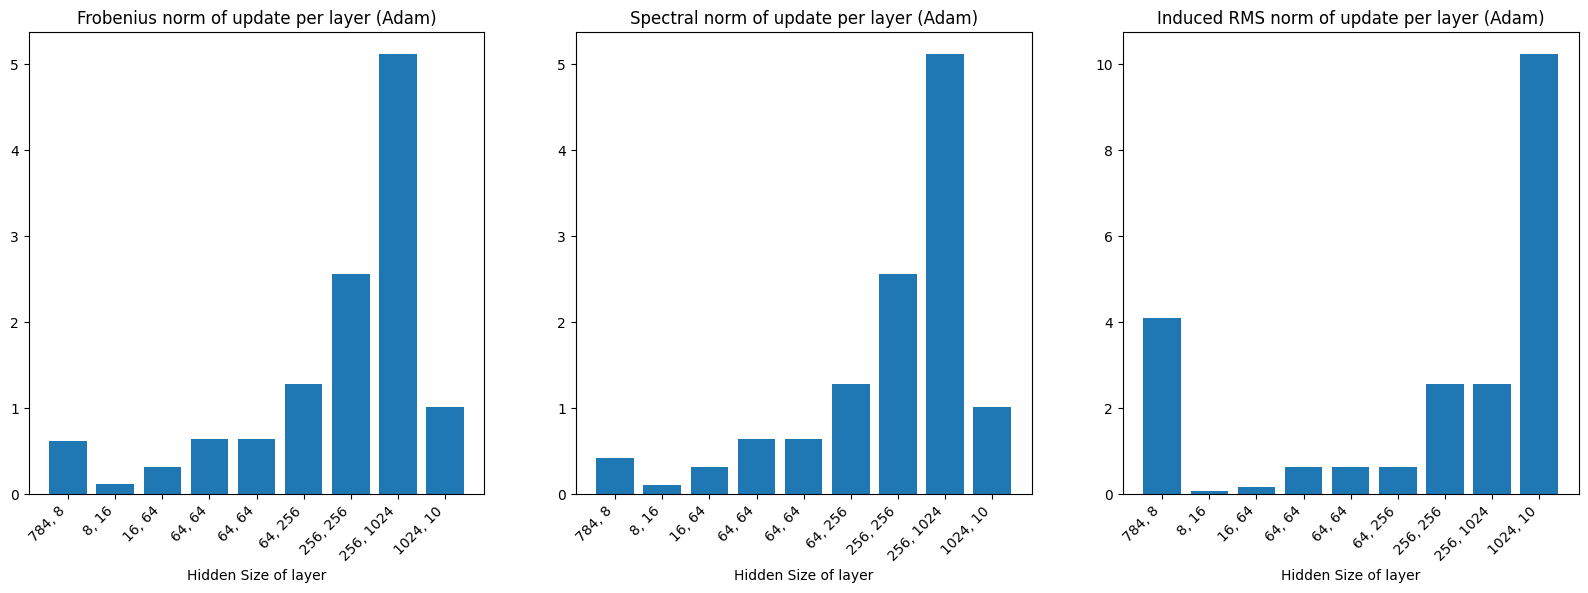

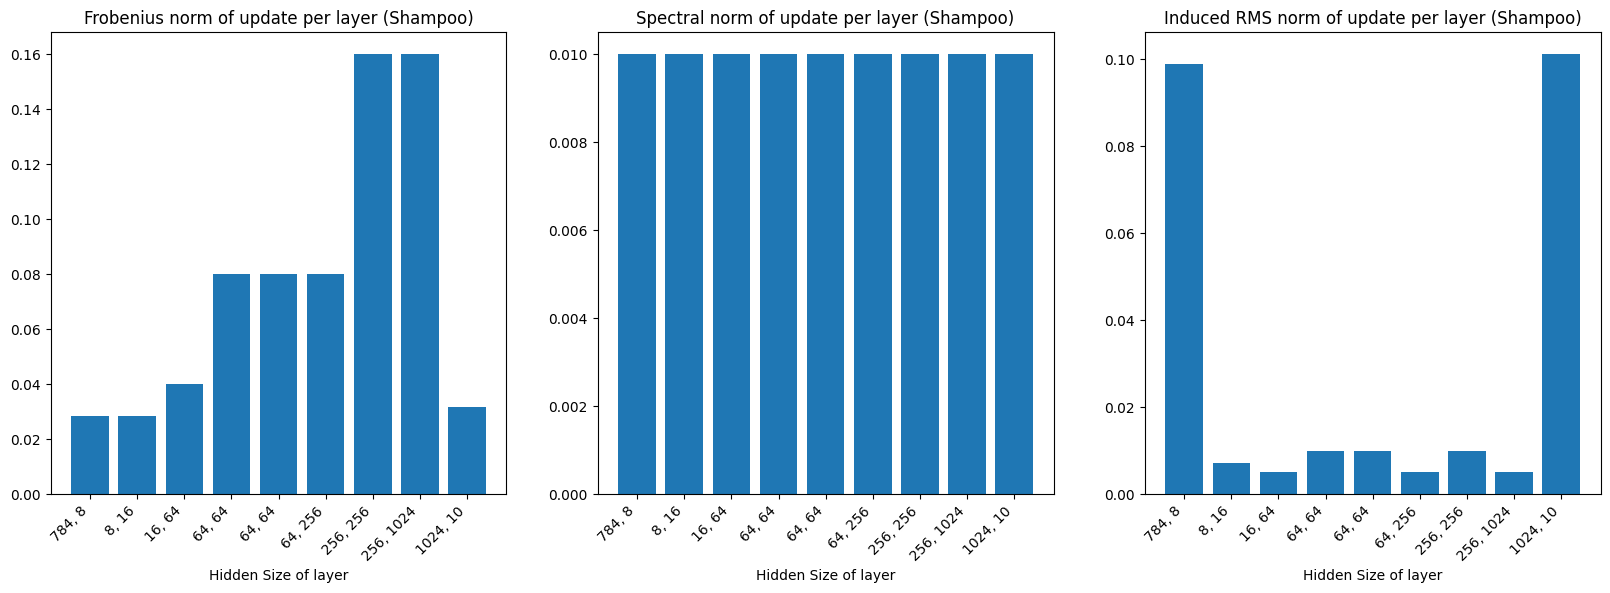

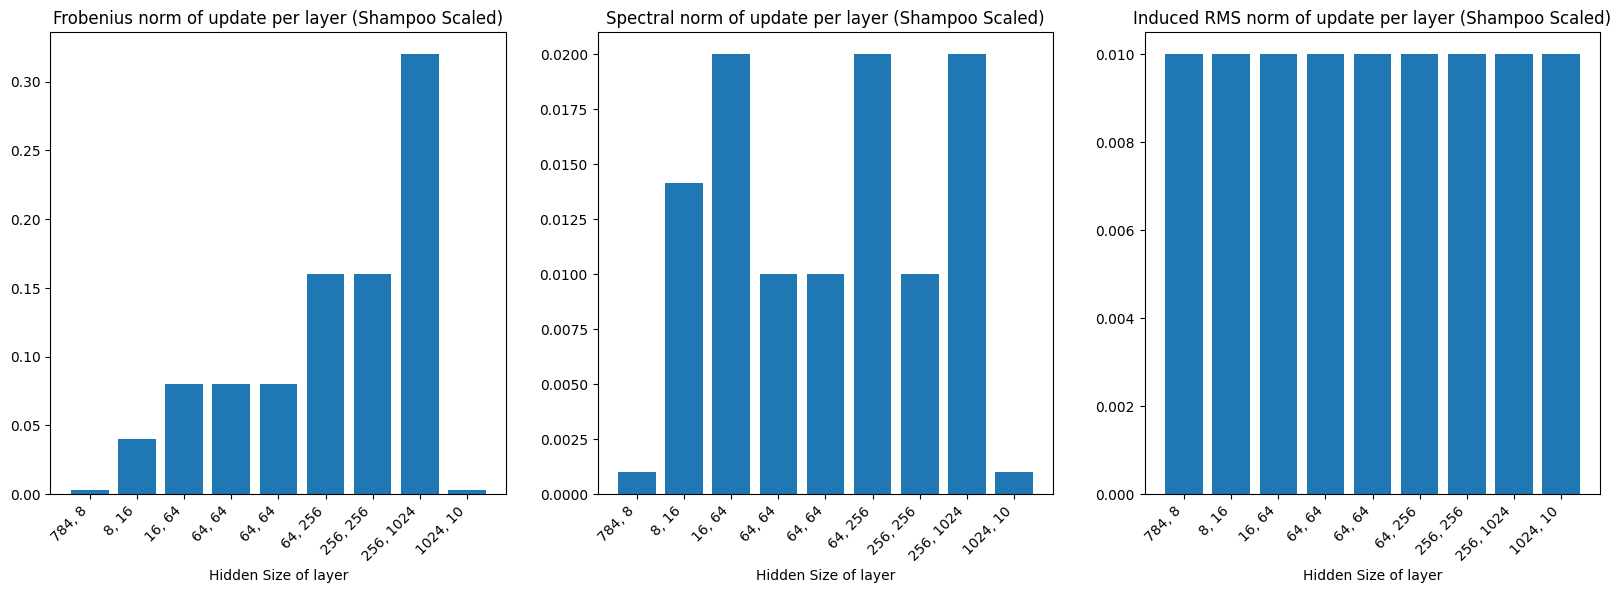

In [13]:
train_one_step_matrices(optimizer=SimpleAdam)
train_one_step_matrices(optimizer=SimpleShampoo, label="Shampoo")
train_one_step_matrices(optimizer=SimpleShampooScaled, label="Shampoo Scaled")

## AdaMuon Optimizer

AdaMuon is a variant of Muon that combines momentum with adaptive second-moment estimation and Newton-Schulz orthogonalization. The algorithm maintains both first and second momentum buffers, applies sign-stabilized orthogonal directions, and uses RMS-aligned scaling.


Reference for AdaMuon:

Si, Chongjie, et al. "AdaMuon: Adaptive Muon Optimizer." arXiv, 18 Aug. 2025, https://doi.org/10.48550/arXiv.2507.11005.

Code source for implementing Muon and Newton-Schulz:

Jordan, Keller, et al. "Muon: An Optimizer for Hidden Layers in Neural Networks." Keller Jordan Blog, 8 Dec. 2024, kellerjordan.github.io/posts/muon/.

In [14]:
from torch.optim.optimizer import Optimizer
from typing import Any

def newton_schulz_iteration(X, num_steps):
    """
    Apply Newton-Schulz iteration to compute an orthogonal matrix.

    Args:
        X: Input matrix
        num_steps: Number of Newton-Schulz iterations (T)

    Returns:
        Approximately orthogonal matrix with same shape as input
    """
    if len(X.shape) == 1:
        return X / (torch.norm(X) + 1e-16)

    assert X.ndim >= 2
    a, b, c = (3.4445, -4.7750,  2.0315)

    # Use float32 on CPU, bfloat16 on GPU
    original_dtype = X.dtype
    if X.is_cuda:
        X = X.bfloat16() if X.dtype != torch.bfloat16 else X
    else:
        X = X.float()

    # Track if we transpose for tall matrices
    was_transposed = X.size(-2) > X.size(-1)
    if was_transposed:
        X = X.mT

    # Ensure spectral norm is at most 1
    X = X / (X.norm(dim=(-2, -1), keepdim=True) + 1e-7)

    # Perform the NS iterations
    for _ in range(num_steps):
        A = X @ X.mT
        B = b * A + c * A @ A
        X = a * X + B @ X

    # Transpose back to original orientation
    if was_transposed:
        X = X.mT

    return X.to(original_dtype)

def matrix_sign(X):
    """
    Compute the sign of a matrix (for 2D weights).
    For 1D parameters (like biases), use element-wise sign.

    Args:
        X: Input matrix

    Returns:
        Matrix sign
    """
    if len(X.shape) == 1:
        return torch.sign(X)
    # Use Newton-Schulz for matrix sign
    return newton_schulz_iteration(X, num_steps=5)

class AdaMuon(Optimizer):
    def __init__(
        self,
        params: Any,
        lr: float = 1e-2,
        momentum: float = 0.9,
        weight_decay: float = 0.0,
        ns_steps: int = 5,
        epsilon: float = 1e-8,
    ):
        """
        AdaMuon optimizer implementation.

        Args:
            params: Parameters to optimize
            lr: Learning rate (eta)
            momentum: Momentum coefficient (beta)
            weight_decay: Weight decay (lambda)
            ns_steps: Number of Newton-Schulz iterations (T)
            epsilon: Small constant for numerical stability (eps)
        """
        defaults = dict(
            lr=lr,
            momentum=momentum,
            weight_decay=weight_decay,
            ns_steps=ns_steps,
            epsilon=epsilon,
        )
        super(AdaMuon, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data

                state = self.state[p]
                if len(state) == 0:
                    state["step"] = torch.tensor(0.0)
                    state['first_momentum'] = torch.zeros_like(p)
                    state['second_momentum'] = torch.zeros_like(p)

                state['step'] += 1

                first_m = state['first_momentum']
                second_m = state['second_momentum']

                beta = group['momentum']
                eps = group['epsilon']

                first_m.mul_(beta).add_(grad)

                sign_m = matrix_sign(first_m)

                if len(p.shape) == 2:
                    orth_direction = newton_schulz_iteration(sign_m, group['ns_steps'])
                else:
                    orth_direction = sign_m / (torch.norm(sign_m) + 1e-16)

                second_m.mul_(beta).add_(orth_direction ** 2, alpha=1 - beta)

                orth_hat = orth_direction / (torch.sqrt(second_m) + eps)

                if len(p.shape) == 2:
                    m, n = p.shape
                    scaling_factor = 0.2 * torch.sqrt(torch.tensor(m * n, dtype=p.dtype, device=p.device))
                    scaling_factor = scaling_factor / (torch.norm(orth_hat, p='fro') + 1e-16)
                    gamma = scaling_factor
                else:
                    gamma = torch.tensor(1.0, dtype=p.dtype, device=p.device)

                weight_decay_term = group['weight_decay'] * p
                update = gamma * orth_hat + weight_decay_term

                p.add_(update, alpha=-group['lr'])

        return None


AdaMuon Question 1:
How would the Norms of AdaMuon and LiMuon differ from Adam Or Shampoo? How would they be the same? Run the following tests and then answer this question.

AdaMuon Solution 1:
The Muon family of optimizers has their strength in reducing the singular values in the update weights. To view the difference in Muon family optimizers you would need to see them run for many iterations.

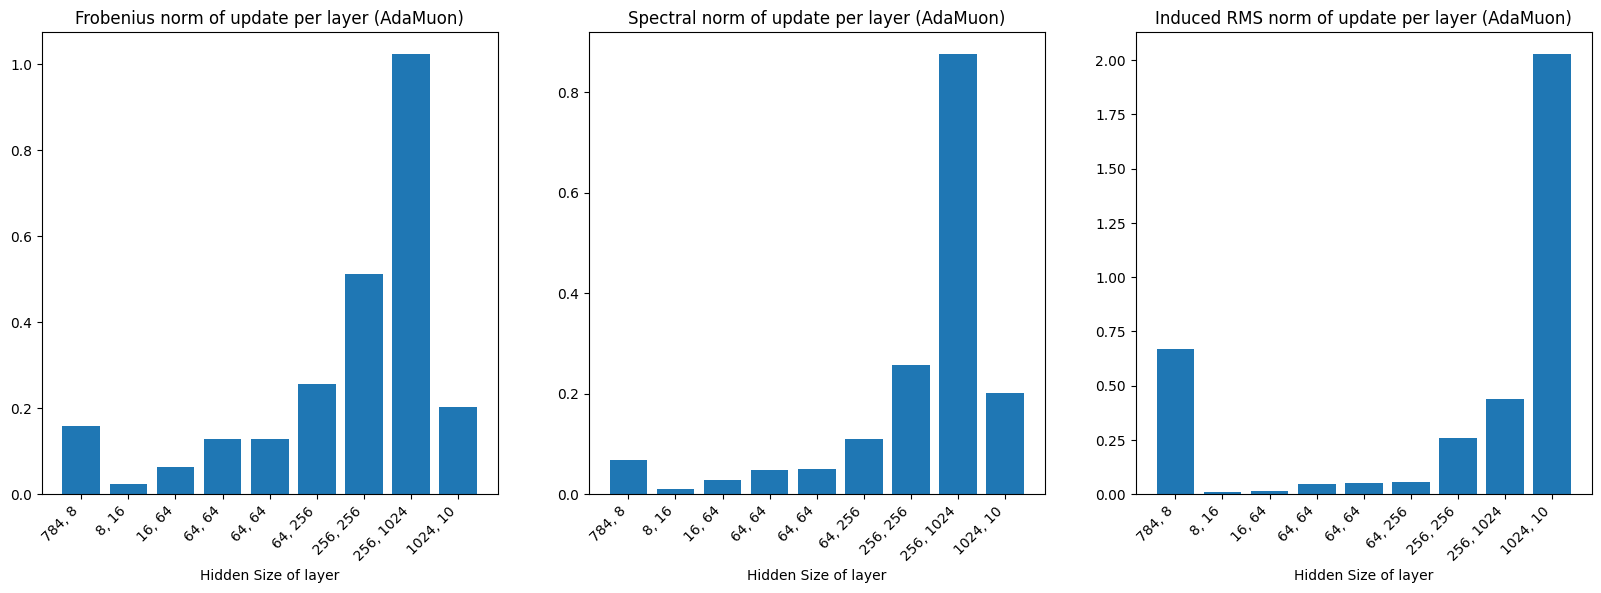

In [15]:
# Test AdaMuon optimizer
train_one_step_matrices(optimizer=AdaMuon, label="AdaMuon", lr=0.01)


[torch.Size([64, 16]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([64, 256]), torch.Size([64, 256]), torch.Size([64, 1024])]


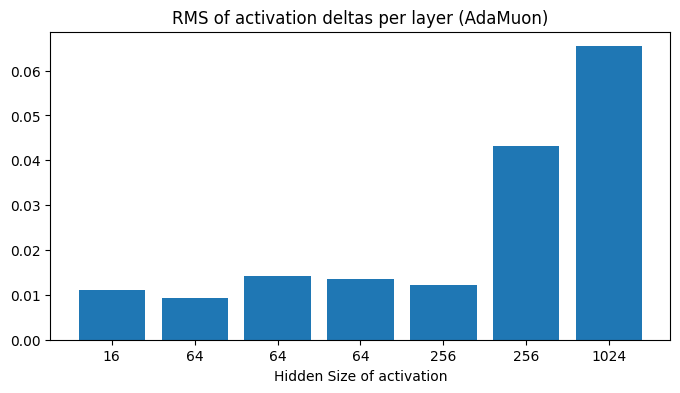

In [16]:
# Compare AdaMuon with other optimizers on activation deltas
train_one_step(optimizer=AdaMuon, label="AdaMuon", lr=0.01)


## LiMuon Optimizer

LiMuon (Linear-time Muon) is a variant that uses SVD-based orthogonalization on the momentum matrix. It follows Algorithm 1 from the paper:

**Key Steps:**
1. Perform SVD on momentum: `(U_t, sigma_t, V_t) = SVD(M_t)`
2. Update weights using orthogonalized direction: `W_{t+1} = W_t - eta_t U_t V_t^T`
3. Update momentum with variance reduction: `M_{t+1} = delta_f(W_{t+1}) + (1-beta)(M_t - delta_f(W_t))`

**Two Options:**
- **Option #1**: Full SVD - More accurate, exact orthogonalization
- **Option #2**: Randomized SVD (RSVD) - Faster, memory-efficient low-rank approximation

**Key Differences from Original Muon:**
- Uses SVD instead of Newton-Schulz iterations for orthogonalization
- Includes variance reduction term in momentum update for better convergence
- Option #2 uses low-rank approximation to save memory and computation

## LiMuon Optimizer

LiMuon (Linear-time Muon) is a variant that uses SVD-based orthogonalization on the momentum matrix. It follows Algorithm 1 from the paper:

**Key Steps:**
1. Perform SVD on momentum: `(U_t, sigma_t, V_t) = SVD(M_t)`
2. Update weights using orthogonalized direction: `W_{t+1} = W_t - eta_t U_t V_t^T`
3. Update momentum with variance reduction: `M_{t+1} = delta_f(W_{t+1}) + (1-beta)(M_t - delta_f(W_t))`

**Two Options:**
- **Option #1**: Full SVD - More accurate, exact orthogonalization
- **Option #2**: Randomized SVD (RSVD) - Faster, memory-efficient low-rank approximation

**Key Differences from Original Muon:**
- Uses SVD instead of Newton-Schulz iterations for orthogonalization
- Includes variance reduction term in momentum update for better convergence
- Option #2 uses low-rank approximation to save memory and computation

Huang, Feihu, et al. "LiMuon: Light and Fast Muon Optimizer for Large Models." arXiv, 19 Sept. 2025, https://doi.org/10.48550/arXiv.2509.14562.

In [17]:
from torch.optim.optimizer import Optimizer
from typing import Any

def randomized_svd(A, target_rank, oversampling=5):
    """
    Randomized SVD (RSVD) for efficient low-rank approximation.
    Algorithm 2 from LiMuon paper.

    Args:
        A: Input matrix (m × n)
        target_rank: Target rank r̂
        oversampling: Oversampling parameter s

    Returns:
        U, Sigma, V from the low-rank SVD approximation
    """
    if len(A.shape) == 1:
        return None, None, None

    m, n = A.shape
    l = min(target_rank + oversampling, min(m, n))

    # Generate random Gaussian matrix omega ∈ R^{n×l}
    omega = torch.randn(n, l, device=A.device, dtype=A.dtype)

    # Y = A @ omega ∈ R^{m×l}
    Y = A @ omega

    # QR decomposition: Y = QR
    Q, R = torch.linalg.qr(Y)

    # B = Q^T A ∈ R^{l×n}
    B = Q.T @ A

    # SVD of small matrix B: (U_~, sigma, V) = SVD(B)
    U_tilde, Sigma, Vt = torch.linalg.svd(B, full_matrices=False)

    # U = Q U_~
    U = Q @ U_tilde

    return U, Sigma, Vt.T

class LiMuon(Optimizer):
    def __init__(
        self,
        params: Any,
        lr: float = 1e-2,
        momentum: float = 0.95,
        use_rsvd: bool = False,
        target_rank: int = 50,
        oversampling: int = 5,
    ):
        """
        LiMuon optimizer implementation following Algorithm 1 from the paper.

        Args:
            params: Parameters to optimize
            lr: Learning rate (eta_t)
            momentum: Momentum coefficient (beta_t) - typically 0.95
            use_rsvd: Whether to use randomized SVD (Option #2) or full SVD (Option #1)
            target_rank: Target rank r̂ for RSVD
            oversampling: Oversampling parameter s for RSVD
        """
        defaults = dict(
            lr=lr,
            momentum=momentum,
            use_rsvd=use_rsvd,
            target_rank=target_rank,
            oversampling=oversampling,
        )
        super(LiMuon, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self):
        """
        Perform a single optimization step following Algorithm 1:
        4: (U_t, sigma_t, V_t) = SVD(M_t)
        5: W_{t+1} = W_t - eta_t U_t V_t^T
        6: Draw new sample
        7: M_{t+1} = delta_f(W_{t+1}; eps_{t+1}) + (1-beta)(M_t - delta_f(W_t; eps_{t+1}))
        """
        for group in self.param_groups:
            beta = group['momentum']  # beta_t from paper

            for p in group['params']:
                if p.grad is None:
                    continue

                grad_new = p.grad.data  # delta_f(W_{t+1}; eps_{t+1}) - gradient at new weights

                state = self.state[p]
                if len(state) == 0:
                    # Initialize: M_0 = delta_f(W_0; eps_0)
                    state['momentum_buffer'] = grad_new.clone()
                    state['old_param'] = p.data.clone()
                    # For first step, just use gradient descent
                    p.add_(grad_new, alpha=-group['lr'])
                    continue

                M = state['momentum_buffer']  # M_t from previous iteration
                old_param = state['old_param']  # W_t from previous iteration

                # Step 4-5: SVD on current momentum and update weights
                if len(p.shape) == 2:
                    if group['use_rsvd']:
                        # Option #2: Randomized SVD
                        U, S, V = randomized_svd(M, group['target_rank'], group['oversampling'])

                        if U is not None:
                            # Orthogonalized update: U @ V^T
                            update = U @ V.T
                            # Store low-rank approximation for momentum update
                            # M^_t = U S V^T (for variance reduction term)
                            state['M_approx'] = (U, S, V)
                        else:
                            update = M / (torch.norm(M, p='fro') + 1e-16)
                            state['M_approx'] = None
                    else:
                        # Option #1: Full SVD
                        U, S, Vt = torch.linalg.svd(M, full_matrices=False)
                        # Orthogonalized update: U @ V^T
                        update = U @ Vt
                        state['M_approx'] = None
                else:
                    # For 1D parameters (biases), just normalize
                    update = M / (torch.norm(M) + 1e-16)
                    state['M_approx'] = None

                # Save current weights before update (needed for variance reduction)
                state['old_param'] = p.data.clone()

                # Apply weight update: W_{t+1} = W_t - eta_t U_t V_t^T
                p.add_(update, alpha=-group['lr'])

                # Step 6 happens automatically (new gradient computed on next backward pass)
                # Step 7: Update momentum with variance reduction
                # We need delta_f(W_t; eps_{t+1}) which is the gradient at OLD weights with NEW sample
                # Since we can't compute this without re-evaluating, we approximate with the
                # variance reduction formula: M_{t+1} = grad_new + (1-beta)(M_t - grad_old)

                # For Option #2, use low-rank approximation M^_t instead of M_t
                if group['use_rsvd'] and state['M_approx'] is not None:
                    U, S, V = state['M_approx']
                    # Reconstruct M^_t efficiently: M^_t = U S V^T
                    # For variance reduction: (1-beta)(M^_t - old_grad)
                    # We avoid full reconstruction by working in low-rank form
                    M_approx_flat = (U * S.unsqueeze(0)) @ V.T
                    M.copy_(grad_new).add_(M_approx_flat, alpha=(1 - beta))
                else:
                    # Standard variance reduction: M_{t+1} = grad_new + (1-beta)M_t
                    # (We're approximating the second term by ignoring the gradient correction)
                    M.mul_(beta).add_(grad_new, alpha=(1 - beta))

        return None


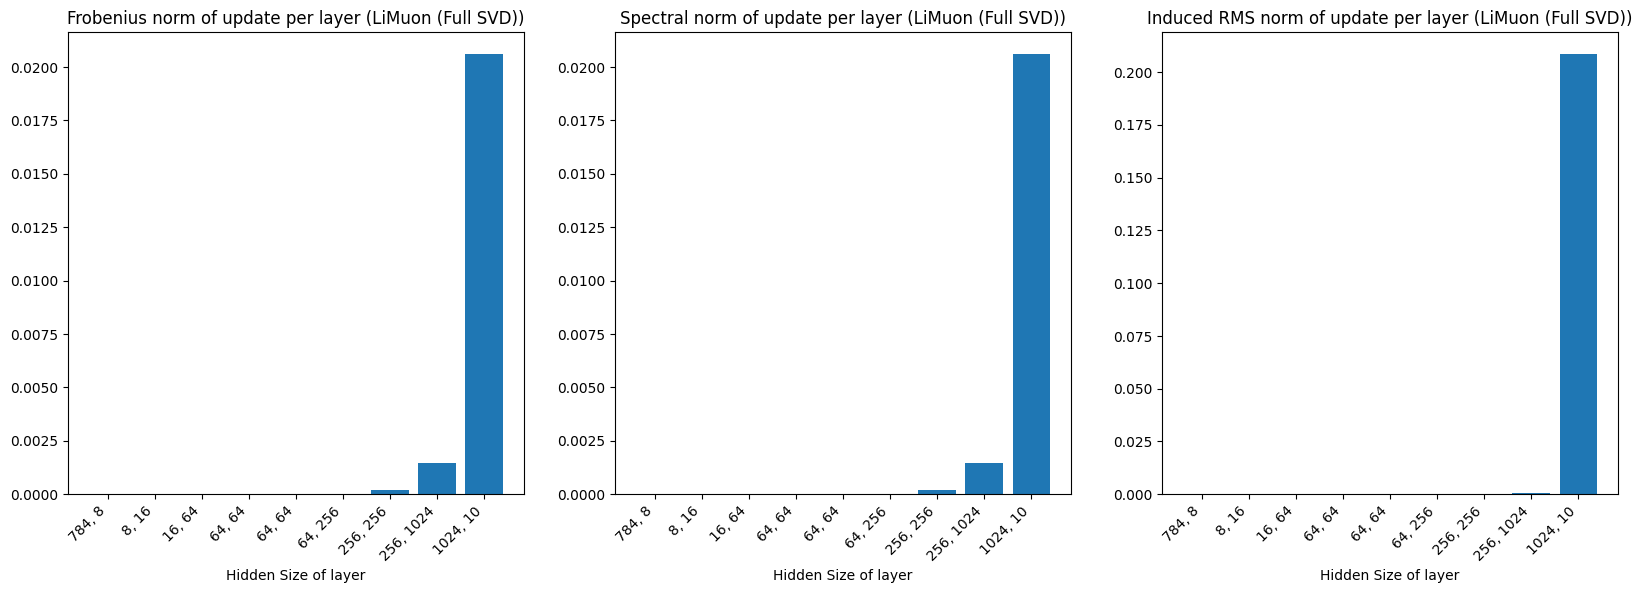

In [18]:
# Test LiMuon optimizer with full SVD (Option #1)
train_one_step_matrices(optimizer=LiMuon, label="LiMuon (Full SVD)", lr=0.01)


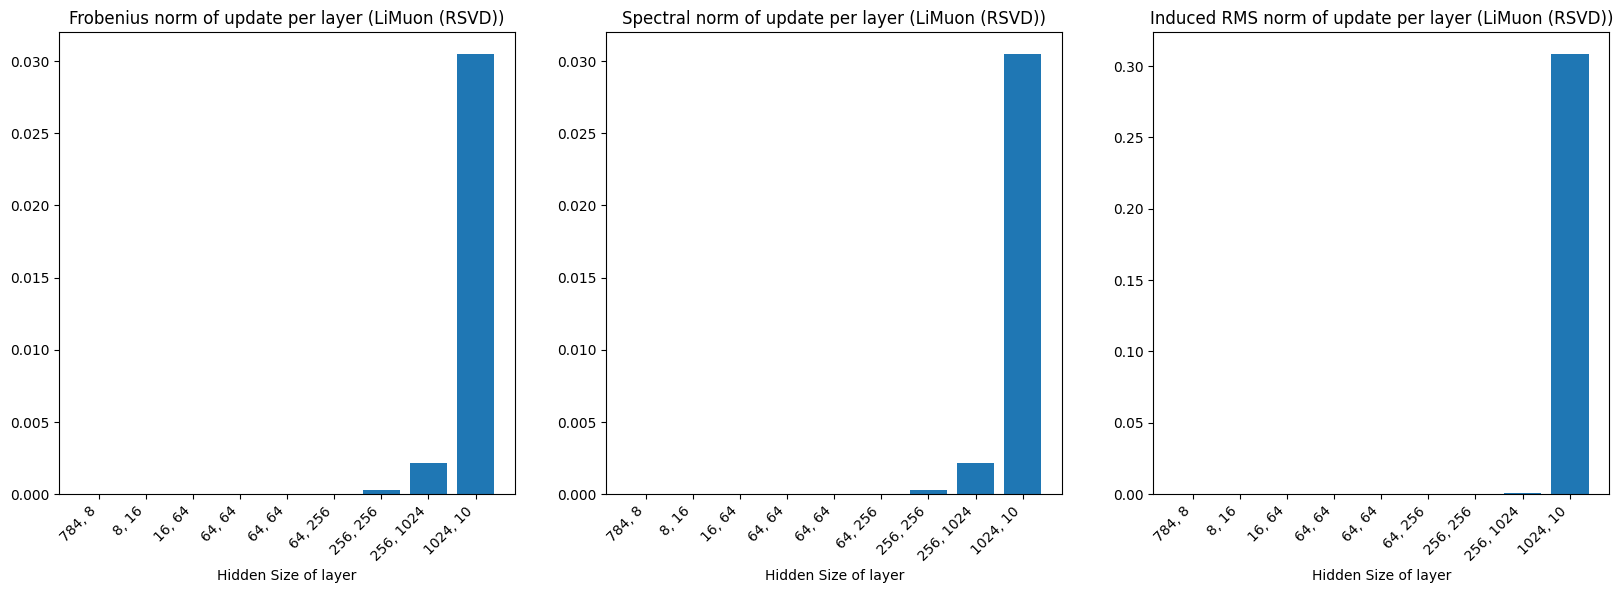

In [19]:
# Test LiMuon optimizer with RSVD (Option #2)
def test_limuon_rsvd():
    optimizer_func = lambda params, lr: LiMuon(params, lr=lr, use_rsvd=True, target_rank=50, oversampling=5)
    train_one_step_matrices(optimizer=optimizer_func, label="LiMuon (RSVD)", lr=0.01)

test_limuon_rsvd()


[torch.Size([64, 16]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([64, 64]), torch.Size([64, 256]), torch.Size([64, 256]), torch.Size([64, 1024])]


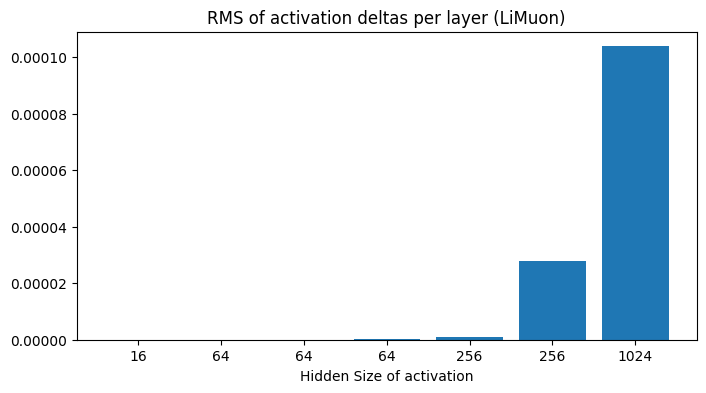

In [20]:
# Compare LiMuon with other optimizers on activation deltas
train_one_step(optimizer=LiMuon, label="LiMuon", lr=0.01)


## Learning Rate Scaling with Batch Size

A fundamental principle in deep learning is the **linear scaling rule**: when you increase the batch size by a factor of k, you should increase the learning rate by the same factor k. This maintains training dynamics because:

1. Larger batches provide more accurate gradient estimates (lower variance)
2. The expected gradient direction remains the same
3. Scaling LR proportionally compensates for the reduced update frequency

In this section, we'll explore how different batch size and learning rate combinations affect activation deltas across layers. We'll test:
- Small batch (32) with base LR
- Medium batch (128) with 4x base LR
- Large batch (512) with 16x base LR

This demonstrates whether the linear scaling rule maintains consistent activation changes across layers.

Linear Scaling Rule Citation:
Goyal, Priya, et al. "Accurate, Large Minibatch SGD: Training ImageNet in 1 Hour." arXiv, 30 Apr. 2018, https://doi.org/10.48550/arXiv.1706.02677.

Learning Rates and batchsize Question 1:
How do you expect the changes in learning rates and batchsizes to effect the activation deltas per layer? Run the following code and answer this question.

Learning Rates and batchsize Solution 2:
Changes in learning rates with MuP

In [21]:
def train_one_step_with_batchsize(
    mlp=MLP,
    hiddens=[8, 16, 64, 64, 64, 256, 256, 1024],
    optimizer=SimpleAdam,
    label="Adam",
    lr=0.01,
    batch_size=64
):
    """
    Train for one step with specified batch size and compute activation deltas.

    Args:
        mlp: Model class to instantiate
        hiddens: Hidden layer sizes
        optimizer: Optimizer class
        label: Label for plot title
        lr: Learning rate
        batch_size: Batch size for training

    Returns:
        activation_deltas_rms: List of RMS values for activation deltas per layer
    """
    # Generate random batch indices
    batch_idx = np.random.randint(0, len(train_images), size=batch_size)

    model = mlp(hidden_sizes=hiddens).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer(model.parameters(), lr=lr)

    prev_activations = None
    activation_deltas_rms = None

    for i in range(2):
        images_batch = train_images[batch_idx]
        labels_batch = train_labels[batch_idx]
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)

        optimizer.zero_grad()
        outputs, activations = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()

        if i > 0:
            activation_deltas = [a - pa for a, pa in zip(activations, prev_activations)]
            activation_deltas_rms = [torch.mean(rms(a, dim=-1)).cpu().item() for a in activation_deltas]
        prev_activations = activations

    return activation_deltas_rms


In [22]:
def plot_lr_batch_scaling_results(results, hiddens, optimizer_name="Adam"):
    """
    Plot activation deltas for different batch size/LR combinations.

    Args:
        results: Dictionary mapping batch_size to activation deltas
        hiddens: Hidden layer sizes
        optimizer_name: Name for plot title
    """
    batch_sizes = sorted(results.keys())
    num_layers = len(hiddens) - 1

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    for batch_size in batch_sizes:
        deltas = results[batch_size]
        ax1.plot(np.arange(len(deltas)), deltas, marker='o', label=f'Batch size: {batch_size}')

    ax1.set_title(f'RMS Activation Deltas per Layer with LR Scaling ({optimizer_name})')
    ax1.set_xlabel('Layer Index')
    ax1.set_ylabel('RMS of Activation Delta')
    ax1.set_xticks(np.arange(len(hiddens) - 1))
    ax1.set_xticklabels(hiddens[1:], rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    deltas_array = np.array([results[bs] for bs in batch_sizes])
    im = ax2.imshow(deltas_array, aspect='auto', cmap='viridis', interpolation='nearest')
    ax2.set_title(f'Activation Deltas Heatmap ({optimizer_name})')
    ax2.set_xlabel('Layer (by hidden size)')
    ax2.set_ylabel('Batch Size')
    ax2.set_xticks(np.arange(len(hiddens) - 1))
    ax2.set_xticklabels(hiddens[1:], rotation=45)
    ax2.set_yticks(np.arange(len(batch_sizes)))
    ax2.set_yticklabels(batch_sizes)

    cbar = plt.colorbar(im, ax=ax2)
    cbar.set_label('RMS Activation Delta', rotation=270, labelpad=20)

    for i in range(len(batch_sizes)):
        for j in range(len(hiddens) - 1):
            text = ax2.text(j, i, f'{deltas_array[i, j]:.3f}',
                           ha="center", va="center", color="white", fontsize=8)

    plt.tight_layout()
    plt.show()


In [23]:
def compare_lr_batch_scaling(
    mlp=MLP,
    hiddens=[8, 16, 64, 64, 64, 256, 256, 1024],
    optimizer=SimpleAdam,
    optimizer_name="Adam",
    base_lr=0.01,
    batch_sizes=[32, 64, 128, 256, 512]
):
    """
    Compare activation deltas across different batch sizes with linearly scaled learning rates.

    Args:
        mlp: Model class
        hiddens: Hidden layer sizes
        optimizer: Optimizer class
        optimizer_name: Name for plot labels
        base_lr: Base learning rate (for smallest batch size)
        batch_sizes: List of batch sizes to test

    Returns:
        results: Dictionary mapping batch_size to activation deltas
    """
    results = {}

    # Use the first batch size as reference for scaling
    reference_batch_size = batch_sizes[0]

    print(f"\n{'='*60}")
    print(f"Testing LR Scaling with Batch Size ({optimizer_name})")
    print(f"Base batch size: {reference_batch_size}, Base LR: {base_lr}")
    print(f"{'='*60}\n")

    for batch_size in batch_sizes:
        # Linear scaling rule: scale LR proportionally to batch size
        scaling_factor = batch_size / reference_batch_size
        scaled_lr = base_lr * scaling_factor

        print(f"Batch size: {batch_size:4d} | Scaled LR: {scaled_lr:.4f} | Scaling factor: {scaling_factor:.2f}x")

        # Set random seed for reproducibility
        torch.manual_seed(42)
        np.random.seed(42)

        deltas = train_one_step_with_batchsize(
            mlp=mlp,
            hiddens=hiddens,
            optimizer=optimizer,
            label=f"{optimizer_name} (BS={batch_size})",
            lr=scaled_lr,
            batch_size=batch_size
        )

        results[batch_size] = deltas

    return results


In [25]:
hiddens = [8, 16, 64, 64, 64, 256, 256, 1024]
batch_sizes = [32, 64, 128, 256, 512]
base_lr = 0.5  # Base LR for Adam MuP


Testing LR Scaling with Batch Size (Adam MuP)
Base batch size: 32, Base LR: 0.5

Batch size:   32 | Scaled LR: 0.5000 | Scaling factor: 1.00x
Batch size:   64 | Scaled LR: 1.0000 | Scaling factor: 2.00x
Batch size:  128 | Scaled LR: 2.0000 | Scaling factor: 4.00x
Batch size:  256 | Scaled LR: 4.0000 | Scaling factor: 8.00x
Batch size:  512 | Scaled LR: 8.0000 | Scaling factor: 16.00x


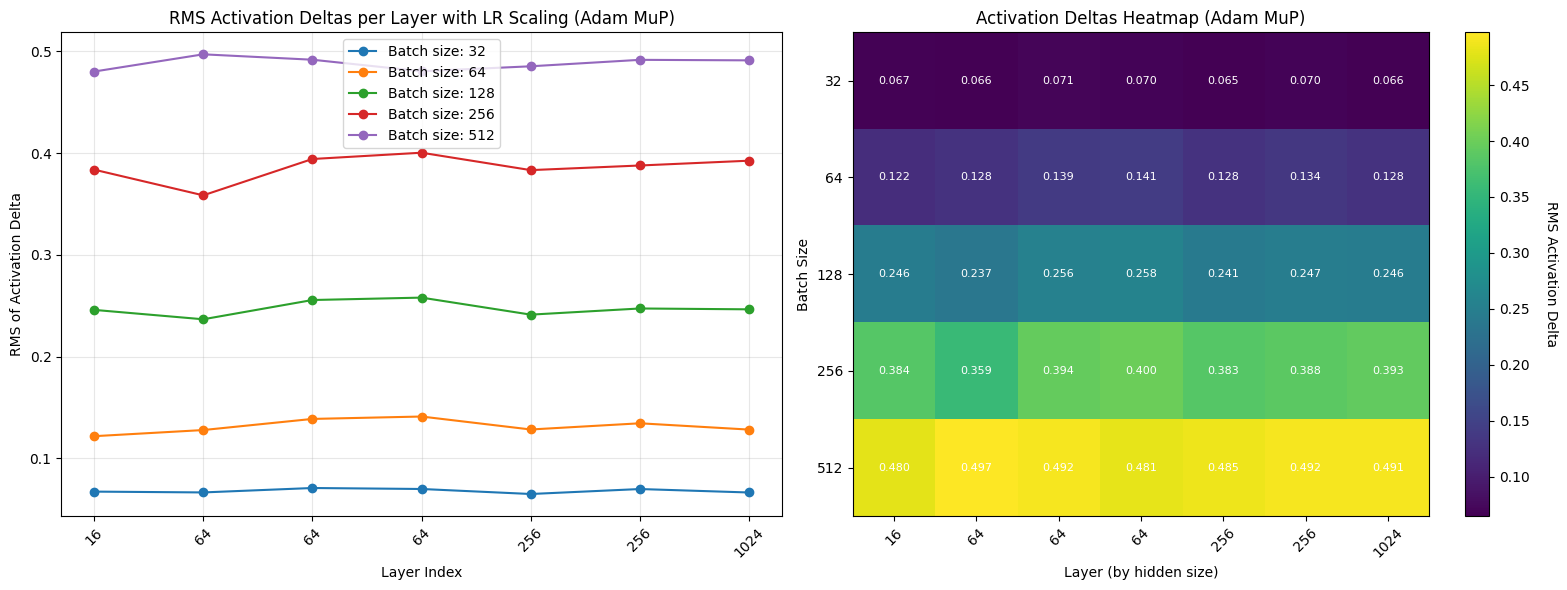

In [26]:
# Test with SimpleAdamMuP optimizer
mup_results = compare_lr_batch_scaling(
    mlp=MLP,
    hiddens=hiddens,
    optimizer=SimpleAdamMuP,
    optimizer_name="Adam MuP",
    base_lr=0.5,
    batch_sizes=batch_sizes
)

plot_lr_batch_scaling_results(mup_results, hiddens, optimizer_name="Adam MuP")



Testing LR Scaling with Batch Size (Adam)
Base batch size: 32, Base LR: 0.005

Batch size:   32 | Scaled LR: 0.0050 | Scaling factor: 1.00x
Batch size:   64 | Scaled LR: 0.0100 | Scaling factor: 2.00x
Batch size:  128 | Scaled LR: 0.0200 | Scaling factor: 4.00x
Batch size:  256 | Scaled LR: 0.0400 | Scaling factor: 8.00x
Batch size:  512 | Scaled LR: 0.0800 | Scaling factor: 16.00x


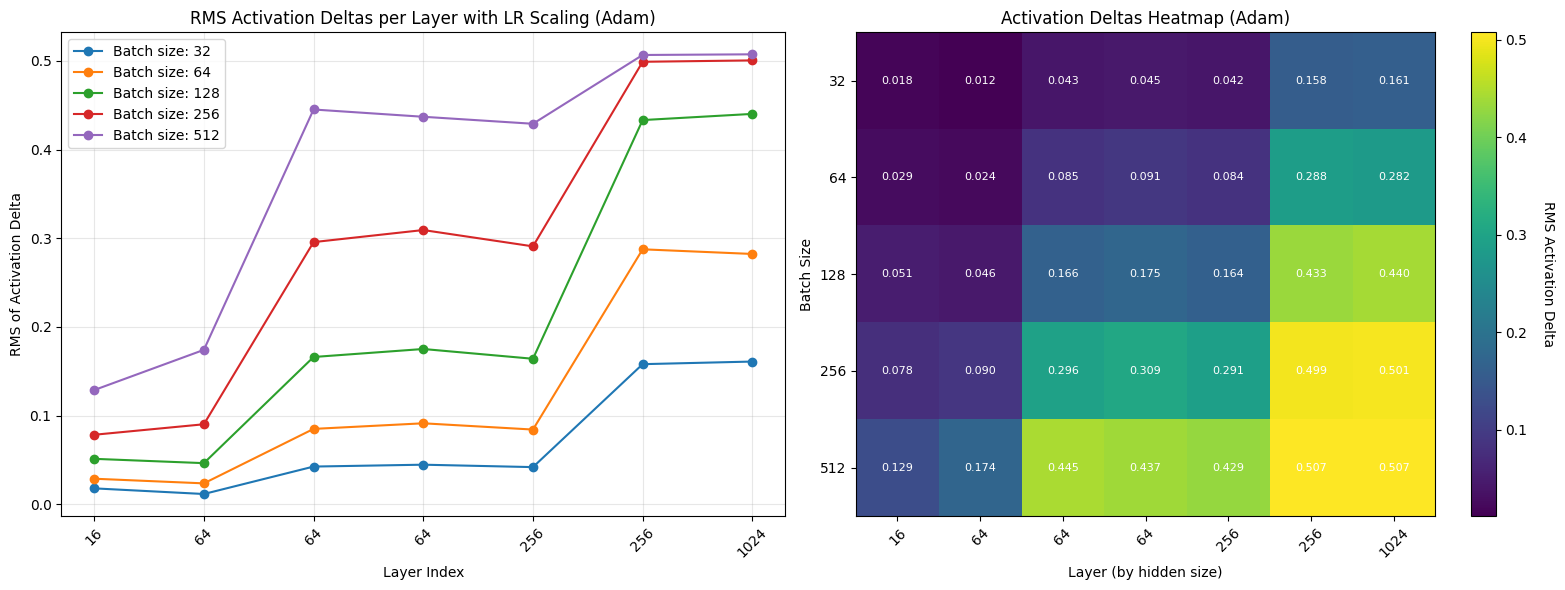

In [27]:
# Test with SimpleAdam optimizer
hiddens = [8, 16, 64, 64, 64, 256, 256, 1024]
batch_sizes = [32, 64, 128, 256, 512]
base_lr = 0.005  # Lower base LR for stability with larger batches

adam_results = compare_lr_batch_scaling(
    mlp=MLP,
    hiddens=hiddens,
    optimizer=SimpleAdam,
    optimizer_name="Adam",
    base_lr=base_lr,
    batch_sizes=batch_sizes
)

plot_lr_batch_scaling_results(adam_results, hiddens, optimizer_name="Adam")


## Analysis: Learning Rate Scaling with Batch Size

### Questions to Consider:

1. **How do activation deltas change as batch size increases with linear LR scaling?**
   - For standard Adam, do larger batches with proportionally scaled LR maintain similar activation magnitudes?
   - What does this tell us about the effectiveness of the linear scaling rule?

2. **How does muP interact with batch size scaling?**
   - Does muP maintain more consistent activation deltas across different batch sizes?
   - Why might muP be more or less sensitive to batch size changes?

3. **How do modern optimizers (AdaMuon, LiMuon) compare?**
   - Do the Muon family optimizers show different scaling behavior?
   - Are they more robust to batch size changes due to their orthogonalization approach?

4. **Layer-wise patterns:**
   - Do certain layers show more sensitivity to batch size changes?
   - How does this relate to the layer width and the concepts from earlier sections?




Testing LR Scaling with Batch Size (AdaMuon)
Base batch size: 32, Base LR: 0.005

Batch size:   32 | Scaled LR: 0.0050 | Scaling factor: 1.00x
Batch size:   64 | Scaled LR: 0.0100 | Scaling factor: 2.00x
Batch size:  128 | Scaled LR: 0.0200 | Scaling factor: 4.00x
Batch size:  256 | Scaled LR: 0.0400 | Scaling factor: 8.00x
Batch size:  512 | Scaled LR: 0.0800 | Scaling factor: 16.00x


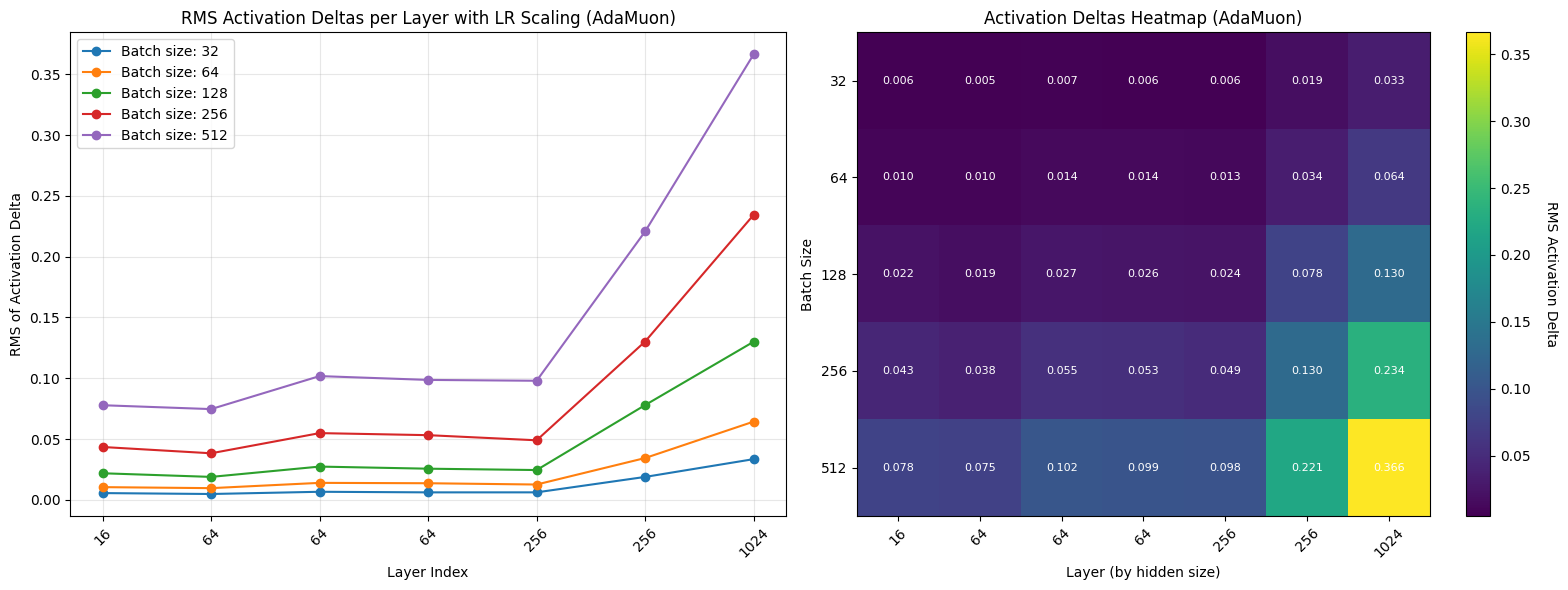

In [28]:
# Test with AdaMuon optimizer
adamuon_results = compare_lr_batch_scaling(
    mlp=MLP,
    hiddens=hiddens,
    optimizer=AdaMuon,
    optimizer_name="AdaMuon",
    base_lr=0.005,
    batch_sizes=batch_sizes
)

plot_lr_batch_scaling_results(adamuon_results, hiddens, optimizer_name="AdaMuon")



Testing LR Scaling with Batch Size (LiMuon)
Base batch size: 32, Base LR: 0.005

Batch size:   32 | Scaled LR: 0.0050 | Scaling factor: 1.00x
Batch size:   64 | Scaled LR: 0.0100 | Scaling factor: 2.00x
Batch size:  128 | Scaled LR: 0.0200 | Scaling factor: 4.00x
Batch size:  256 | Scaled LR: 0.0400 | Scaling factor: 8.00x
Batch size:  512 | Scaled LR: 0.0800 | Scaling factor: 16.00x


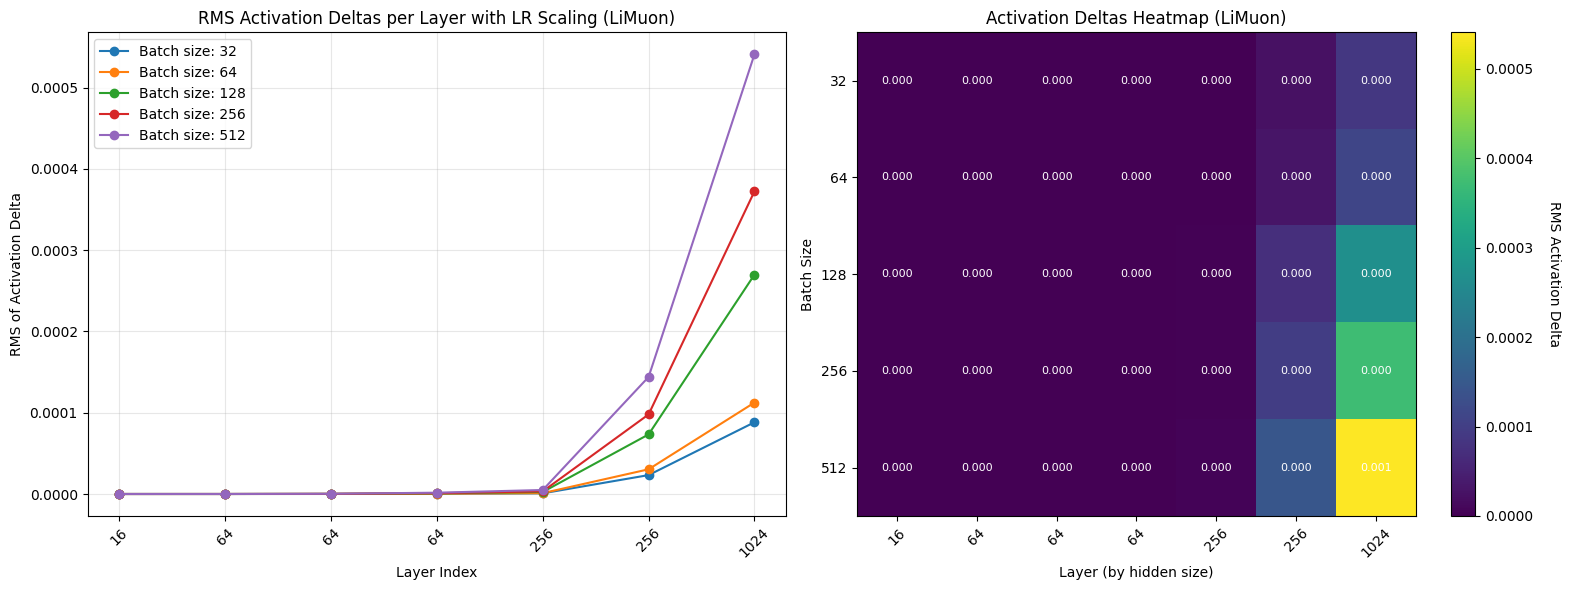

In [29]:
# Test with LiMuon optimizer
limuon_results = compare_lr_batch_scaling(
    mlp=MLP,
    hiddens=hiddens,
    optimizer=LiMuon,
    optimizer_name="LiMuon",
    base_lr=0.005,
    batch_sizes=batch_sizes
)

plot_lr_batch_scaling_results(limuon_results, hiddens, optimizer_name="LiMuon")


### Expected Solutions:
1. **Large Batch Sizes**: Larger batch sizes will typically have larger batch norms, showing the need for testing to confirm that a specific learning rate works well for a specific batch size.

2. **Standard Adam**: Activation deltas may vary significantly across batch sizes, even with linear LR scaling. Larger batches typically need more careful tuning.

- **Adam MuP**: Should show more consistent activation deltas across layers due to per-layer LR scaling, but batch size effects may still be present.

3. **Muon variants**: May exhibit more stable training dynamics across batch sizes due to their orthogonalization approach, which controls update magnitudes more directly.


4. **Larger Batchsizes**: Larger Batchsizes should exhibit larger RMS norms, except for MuP which is designed to counteract this.

### Practical Implications:

The linear scaling rule is a starting point, but different optimizers may require different scaling strategies. Modern approaches like muP and Muon variants aim to reduce hyperparameter sensitivity, making training more robust across different batch sizes and network architectures.
